In [1]:
import gym
import numpy as np
import math
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path


class PendulumEnv1(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 30
    }

    def __init__(self, g=10.0):
        self.max_speed = 8
        self.max_torque = 100.
        self.dt = .05
        self.g = g
        self.m = 1.
        self.l = 1.
        self.viewer = None

        high = np.array([1., 1., self.max_speed], dtype=np.float32)
        self.action_space = spaces.Box(
            low=-self.max_torque,
            high=self.max_torque, shape=(1,),
            dtype=np.float32
        )
        self.observation_space = spaces.Box(
            low=-high,
            high=high,
            dtype=np.float32
        )

        self.seed()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, u):
        th, thdot = self.state  # th := theta

        g = self.g
        m = self.m
        l = self.l
        dt = self.dt

        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u  # for rendering
        costs = angle_normalize(th) ** 2 + .1 * thdot ** 2 + .001 * (u ** 2)

        newthdot = thdot + (-3 * g / (2 * l) * np.sin(th + np.pi) + 3. / (m * l ** 2) * u) * dt
        newth = th + newthdot * dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)

        self.state = np.array([newth, newthdot])
        return self._get_obs(), -costs, False, {}

    def reset(self):
        high = np.array([np.pi, 1])
        self.state = self.np_random.uniform(low=-high, high=high)
        self.last_u = None
        return self._get_obs()

    def _get_obs(self):
        theta, thetadot = self.state
        return np.array([np.cos(theta), np.sin(theta), thetadot])

    def render(self, mode='human'):
        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(500, 500)
            self.viewer.set_bounds(-2.2, 2.2, -2.2, 2.2)
            rod = rendering.make_capsule(1, .2)
            rod.set_color(.8, .3, .3)
            self.pole_transform = rendering.Transform()
            rod.add_attr(self.pole_transform)
            self.viewer.add_geom(rod)
            axle = rendering.make_circle(.05)
            axle.set_color(0, 0, 0)
            self.viewer.add_geom(axle)
            fname = path.join(path.dirname(__file__), "assets/clockwise.png")
            self.img = rendering.Image(fname, 1., 1.)
            self.imgtrans = rendering.Transform()
            self.img.add_attr(self.imgtrans)

        self.viewer.add_onetime(self.img)
        self.pole_transform.set_rotation(self.state[0] + np.pi / 2)
        if self.last_u:
            self.imgtrans.scale = (-self.last_u / 2, np.abs(self.last_u) / 2)

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None


def angle_normalize(x):
    return (((x+np.pi) % (2*np.pi)) - np.pi)

In [3]:
class pdController:
    def __init__(self, kp: float, kd: float, set_point=0):
        self.kp, self.kd = kp, kd
        self.set_point = set_point

    def stepController(self, state, set_point):
        p = self.kp * (set_point - state[0])
        d = self.kd * (0 - state[1])
        torque = p + d

        return np.array([torque])

In [14]:

class PendulumEnv:
    """ Wrapper over the original gym pendulum environment to only return the theta (angle) as observation"""

    def __init__(self):
        self.env = PendulumEnv1()
        # self.env.max_torque = 50

    def seed(self, *args, **kwargs):
        self.env.seed(*args, **kwargs)

    def reset(self):
        obs = self.env.reset()        
        return self.obs2Polar(obs) # convert to polar coord

    def step(self, action, **kwargs):
        #NOTE: very bs thing from gym obs definition, it outputs x, y, velocity, but x and y are actually flipped in coordinate
        # to use the controller, we have to define in joint coordinate, env.env.state returns the angles from -180 to 180
        # idk why they want to define in this way rather than just 0 to 360. 
        # So we use original obs and convert back to polar coordinate in 0 to 360 covnetion. 
        obs, reward, done, info = self.env.step(action, **kwargs)
        return self.obs2Polar(obs), reward, done, info

    def render(self, *args, **kwargs):
        return self.env.render(*args, **kwargs)

    def obs2Polar(self, obs):
        if self.env.state[0] < 0:
            theta = np.pi - np.abs(self.env.state[0]) + np.pi
        else:
            theta = self.env.state[0]
        return np.array([theta, self.env.state[1]])

    # deprecated
    def _get_obs(self):
        theta, dtheta = self.env.state
        return np.array([theta, dtheta])

    def close(self, *args, **kwargs):
        return self.env.close(*args, **kwargs)


In [15]:
# create controller and reset it
pdCtrl = pdController(kp=50, kd=2, set_point=np.deg2rad(0))
# the torque limit on the env is very small, so the PD controller is very hard to balance back to inverted top
# it will most generate the bang-bang control, because it does not know the natural dynamics, basically this is all the algo is doing with direct torque control
# but given a narrow range of initial states, it should work ok. not expect to be anle to solve all. 

In [16]:
# create, initialize and reset the environment.
env = PendulumEnv()
env.seed(1)
obs = env.reset()


In [17]:
env.env.max_torque

100.0

In [18]:
# create, initialize and reset the environment.
env = PendulumEnv()
env.seed(1)
obs = env.reset()

# episode trackers
done = False
episode_reward = 0
ep_obs = []
ep_action =[]
sim_u = []
render = False

if render:
    img = plt.imshow(env.render(mode='rgb_array')) # render window

# interact with the environment till termination.

set_point = np.deg2rad(90)
set_point_history=[]
for i in range(500):
    print(i)
    # render
    if render:
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)

    # step
    action = pdCtrl.stepController(obs, set_point)
    ep_obs.append(math.degrees(obs[0]))
    ep_action.append(action)
    sim_u.append(env.env.last_u)
    obs, reward, done, _ = env.step(action)
    episode_reward += reward
    set_point_history.append(set_point)
    
    if i % 25 ==0:
        set_point -= np.deg2rad(15)
        set_point = max(np.deg2rad(0),set_point)
        print(np.rad2deg(set_point))

env.close()


0
75.0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
60.00000000000001
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
45.000000000000014
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
30.000000000000018
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
15.000000000000018
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
1.90833280887811e-14
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
0.0
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
0.0
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
0.0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
0.0
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
2

### `Plots`

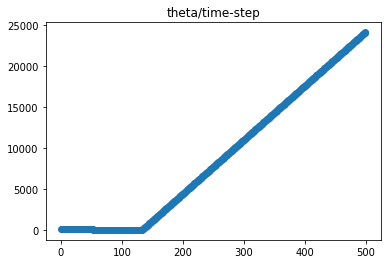

In [19]:
plt.plot(ep_obs,marker='o')
plt.title('theta/time-step')
plt.show()

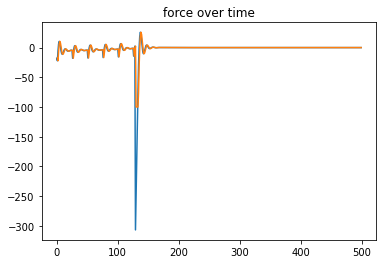

In [12]:
plt.plot(ep_action)
plt.plot(sim_u)
plt.title('force over time')
plt.show()

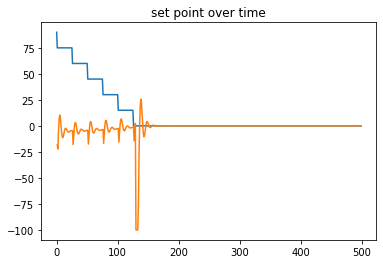

In [13]:
plt.plot([np.rad2deg(s) for s in set_point_history])
plt.plot(sim_u)
plt.title('set point over time')
plt.show()